In [58]:
# imports
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import xarray as xr 
import pandas as pd 
import datetime
import glob
from util import smooth_data
from shapely.geometry import Point
import matplotlib.colors as mcolors

from dirs import asodatadir, datadir
# plot style
plt.style.use('/Users/cowherd/Documents/mplstyles/marianne.mplstyle')



## aso data
fns = glob.glob(f'{asodatadir}/*American*/*.tif')
dates = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']
vars50 = ['NIRalbedo_50m','BBalbedo_50m', 'snowdepth_50m', 'swe_50m']
vars3 = ['snowdepth_3m', 'swe_3m']
fn = glob.glob(f'{asodatadir}/*American*/*American*{dates[0]}*{vars50[-1]}.tif')[0]
ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')


caldor = gpd.read_file(f'{datadir}/caldor.shp').to_crs('epsg:4326')
srtm = xr.open_dataarray(f'{datadir}/srtm30_sfa.nc')
cldrstr = 'ca3858612053820210815'
cldrdate= '20210805_20220723'
mtbs_rdnbr = xr.open_dataset(f'{datadir}/{cldrstr}/{cldrstr}_{cldrdate}_rdnbr.tif')
srtm = srtm.rio.write_crs('epsg:4326').rename({'lat':'y','lon':'x'})
srtm_50 = srtm.rio.reproject_match(ds_50m)


watershed = gpd.read_file(f'{datadir}/eldoradohuc8.shp')
sfa = watershed[watershed.name == 'South Fork American']
cap23 = pd.read_csv(f'{datadir}/cap23.csv', parse_dates = True, index_col = 0)

slope_data = np.arctan(np.sqrt(np.gradient(srtm_50.values, axis=0)**2 + np.gradient(srtm_50.values, axis=1)**2))

# Create a new xarray dataset for the slope
slope_da = xr.DataArray(slope_data, coords=srtm_50.coords, dims=srtm_50.dims, name='slope')

# Create an xarray dataset for the slope
slope_50 = xr.Dataset({'slope': np.degrees(slope_da)})
grad_x = np.gradient(srtm_50, axis=0)
grad_y = np.gradient(srtm_50, axis=1)
aspect_data = np.arctan2(-grad_x, grad_y) * 180 / np.pi  # Convert to degrees

# Create a new xarray dataset for the aspect
aspect_da = xr.DataArray(aspect_data, coords=srtm_50.coords, dims=srtm_50.dims)

# Create an xarray dataset for the aspect
aspect_50 = xr.Dataset({'aspect': aspect_da})

caldormeta = pd.read_csv(f'{datadir}/caldormeta.csv').drop(columns = ['camera_serial'])
caldormeta['geometry'] = [Point(float(lon), float(lat)) for lon, lat in zip(caldormeta['lon'], caldormeta['lat'])]
caldormeta = gpd.GeoDataFrame(caldormeta, crs='EPSG:4326')

hobo_camera = pd.read_csv(f'{datadir}/hobo_camera_id.csv').astype(int)
cameraid = pd.read_csv(f'{datadir}/camera_id.csv').astype(int)

merged_df = pd.merge(caldormeta, hobo_camera, on='plot_number', how='left')
merged_df = pd.merge(merged_df, cameraid, on='plot_number', how='left')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.lon, merged_df.lat))


mtbs_rdnbr_50 = mtbs_rdnbr.rio.reproject_match(ds_50m)


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/1918391076.py:25: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [21]:
def replace_dashes(indata, index):
    newtmp = []
    for val in indata:
        if val == '--':
            newtmp.append(np.nan)
        else:
            newtmp.append(float(val))
    outdata = pd.DataFrame({'SNOWDEPTHIN': newtmp}, index = index)
    return outdata

def get_file_name(fn):
    return fn.split('_')[-2]

files = glob.glob('../data/*_SD.csv')
monthlySD = {}
for fn in files:
    name = fn.split('/')[-1][0:3]

    tmp = pd.read_csv(fn, parse_dates = True, index_col = 0)
    newtmp = replace_dashes(tmp['SNOW DP INCHES'], tmp.index)
    monthlySD[name] = newtmp


In [22]:
fnsp = glob.glob('../data/processed/*_processsed.csv')
monthyl_sd = np.load('../data/monthlySD.npy', allow_pickle = True).item()

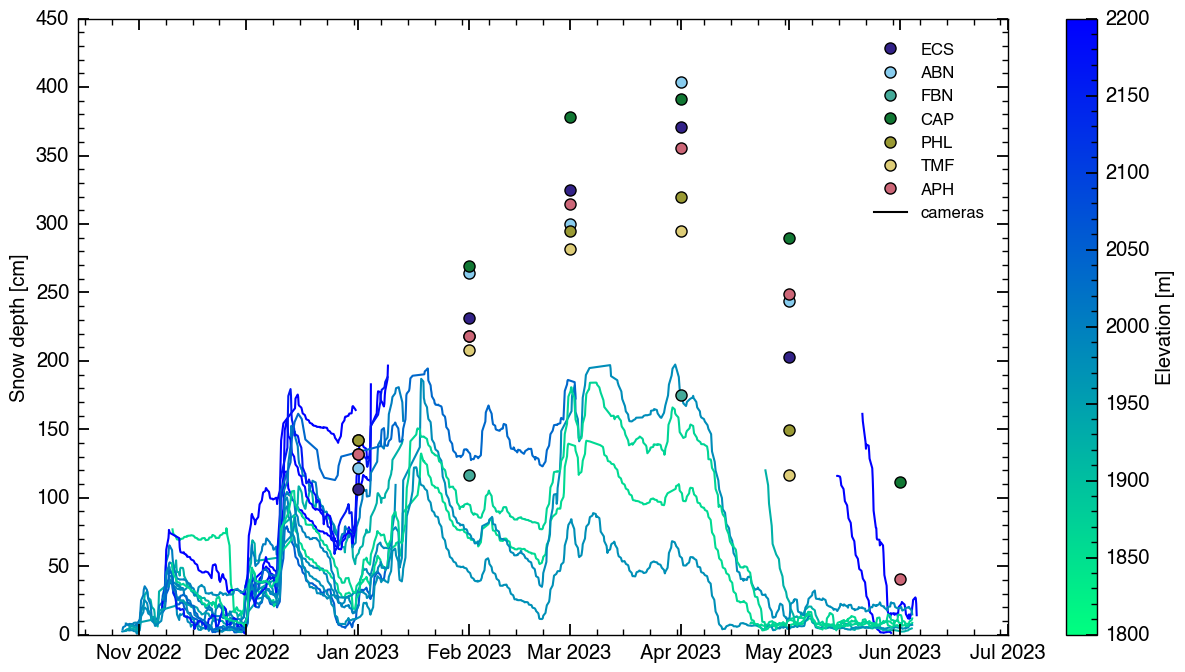

In [23]:
IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=get_file_name(fn)
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = gdf[gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'black', label = 'cameras')
l1 = 17
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[l1:], labels[l1:])
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((0,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))
    

plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/668928778.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/668928778.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/668928778.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/668928778.py:8: DeprecationWarnin

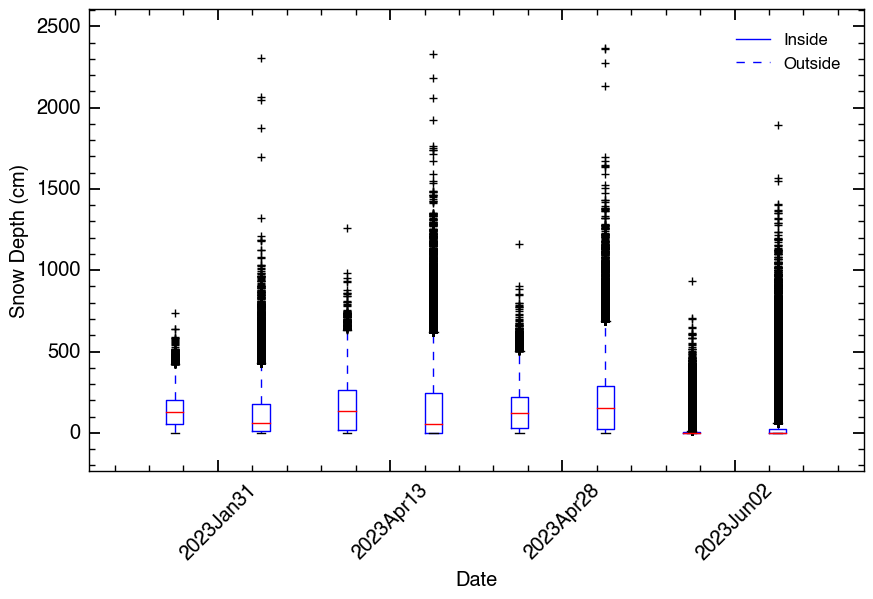

In [33]:

dates = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']

inside_values = []
outside_values = []

for date in dates:
    fn = glob.glob(f'{asodatadir}/*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    ds = ds.rio.clip(sfa.geometry)
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
    inside = inside.where(inside >=0)
    outside = outside.where(outside >=0)
    
    ins = inside.values.flatten() * 100
    out = outside.values.flatten() * 100
    
    inside_values.append(ins[~np.isnan(ins)])
    outside_values.append(out[~np.isnan(out)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(inside_values, positions=np.arange(len(dates)), widths=0.1)
ax.boxplot(outside_values, positions=np.arange(len(dates)) + 0.5, widths=0.1)

ax.set_xticks(np.arange(len(dates)) + 0.25)
ax.set_xticklabels(dates, rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Snow Depth (cm)')
ax.legend(['Inside', 'Outside'])

plt.show()

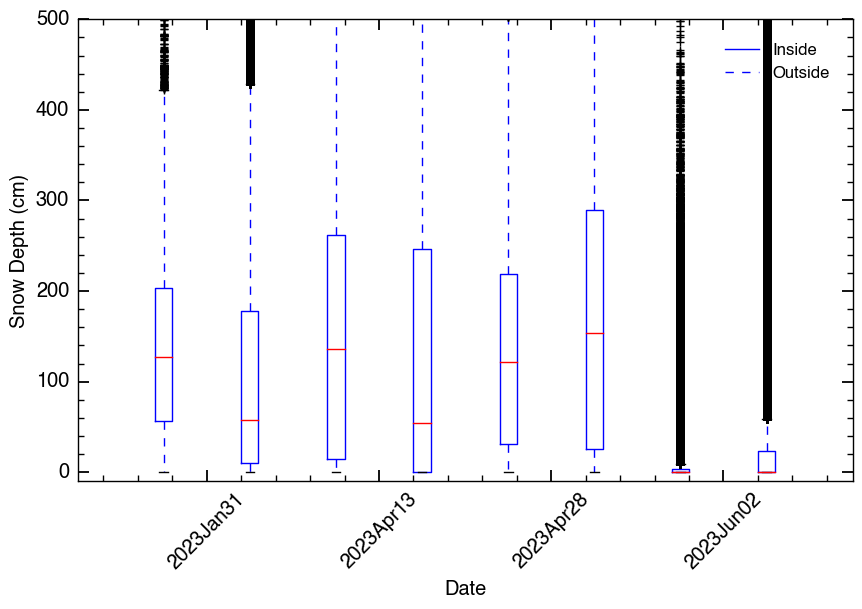

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(inside_values, positions=np.arange(len(dates)), widths=0.1)
ax.boxplot(outside_values, positions=np.arange(len(dates)) + 0.5, widths=0.1)

ax.set_xticks(np.arange(len(dates)) + 0.25)
ax.set_xticklabels(dates, rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Snow Depth (cm)')
ax.legend(['Inside', 'Outside'])
ax.set_ylim((-10,500))
plt.show()

In [35]:
dates_dt = [datetime.datetime(2023,1,31), datetime.datetime(2023,4,13), datetime.datetime(2023,4,28), datetime.datetime(2023,6,2)]
import matplotlib.dates as mdates

dates_num = mdates.date2num(dates_dt)

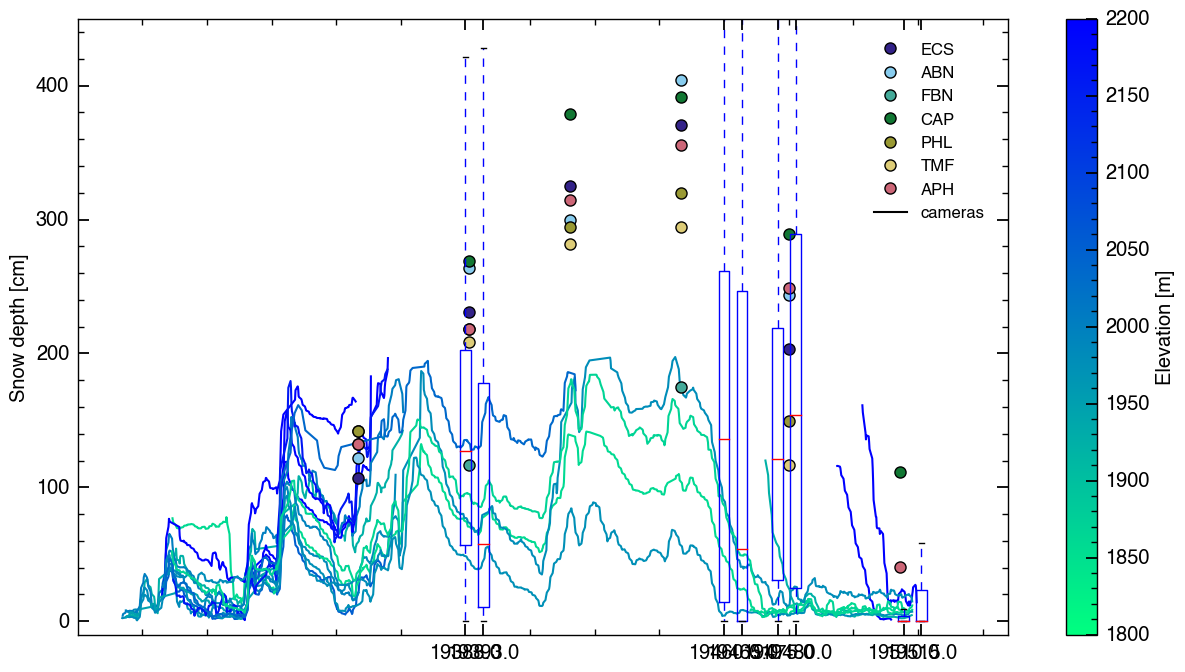

In [37]:
IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=get_file_name(fn)
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = gdf[gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'black', label = 'cameras')
l1 = 17
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[l1:], labels[l1:])
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))


ax.boxplot(inside_values, positions=dates_num, widths=3, showfliers=False)
ax.boxplot(outside_values, positions=dates_num + 5, widths=3, showfliers=False)

plt.show()

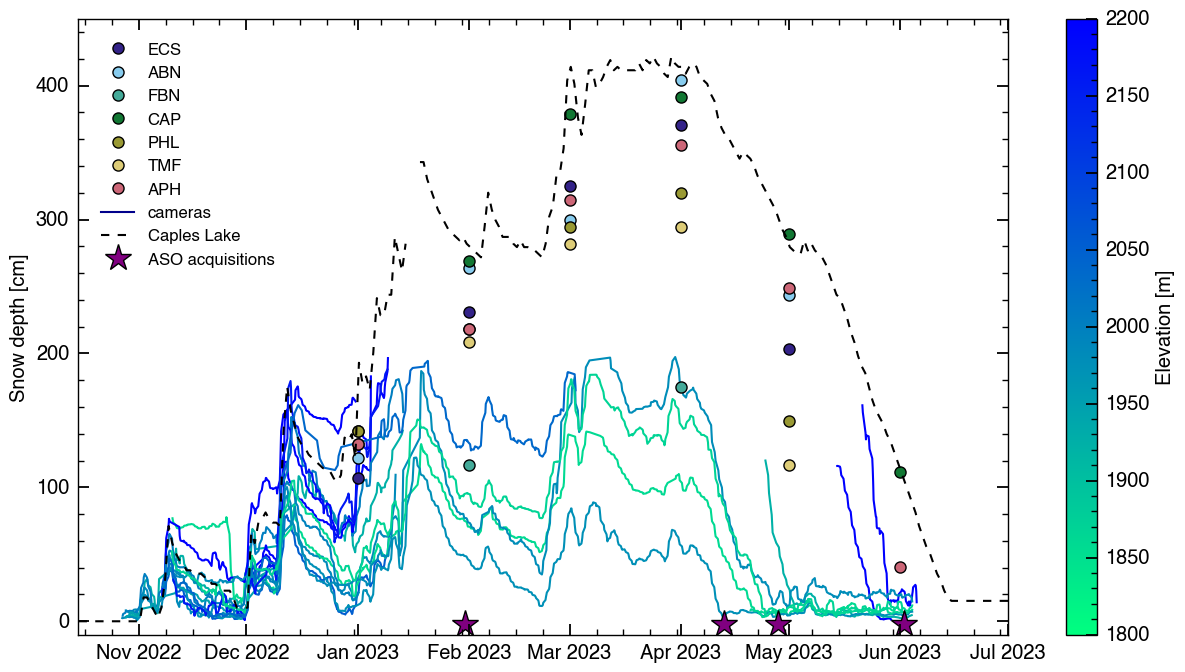

In [41]:
IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=get_file_name(fn)
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = gdf[gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'darkblue', label = 'cameras')
l1 = 17

ax.plot(pd.DatetimeIndex(cap23.datetime), cap23.SNOWDEPTH * 2.54, linestyle = '--', label = 'Caples Lake')

aso_dates = [datetime.datetime(2023,1,31), datetime.datetime(2023,4,13), datetime.datetime(2023,4,28), datetime.datetime(2023,6,2)]

ax.plot(aso_dates, [-2,-2,-2,-2], '*', color = 'purple', label = 'ASO acquisitions', markersize = 20)


handles, labels = ax.get_legend_handles_labels()
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))

ax.legend(handles[l1:], labels[l1:], loc = 'upper left')

months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# Format the x tick labels as Month, Year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.show()

In [43]:
categories = ["Regrowth", "Unburned", "Low", "Moderate", "High"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red"]
# Define the burn severity categories and their cutoff values
bounds = [-5000, -100, 70, 315, 640, 5000]

# Create an empty dictionary to store masks for each category
category_masks = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = categories[i]

    # Create a mask for the current category
    mask = (mtbs_rdnbr_50 >= lower_bound) & (mtbs_rdnbr_50 < upper_bound)

    # Add the mask to the dictionary with the category label as the key
    category_masks[category_label] = mask


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/2953885523.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/2953885523.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/2953885523.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(fn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/2953885523.py:15: Deprecati

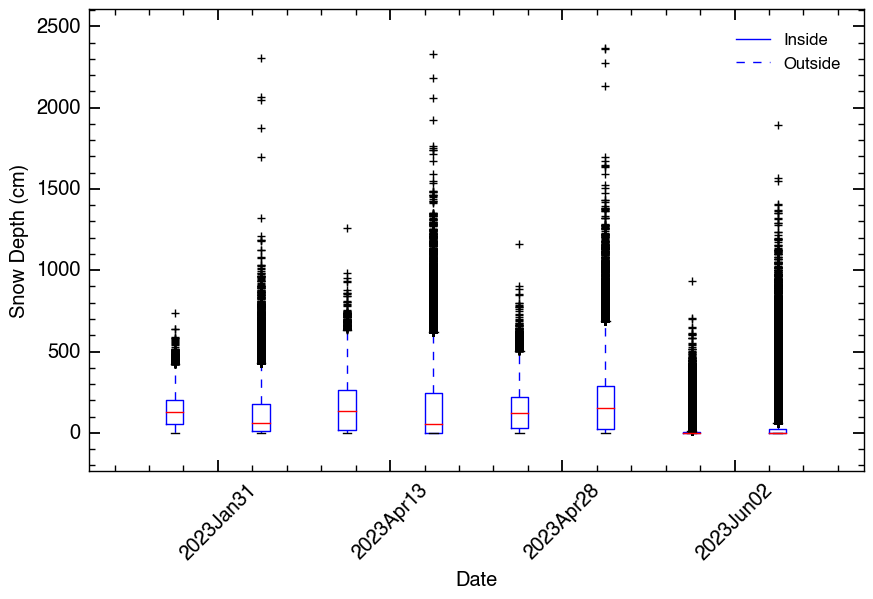

In [44]:
import matplotlib.pyplot as plt
import numpy as np
dates = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']

inside_values = []
outside_values = []
categ_vals = {}
regrowth_values = []
unburned_values = []
low_values = []
moderate_values = []
high_values = []
for date in dates:
    fn = glob.glob(f'{asodatadir}/*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(fn)
    ds = ds.rio.reproject('epsg:4326')
    ds = ds.rio.clip(sfa.geometry)
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
    inside = inside.where(inside >=0)
    outside = outside.where(outside >=0)
    
    
    in_cat = inside.where(category_masks['Regrowth']).sel(band=1).band_data.values.flatten() * 100
    regrowth_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Unburned']).sel(band=1).band_data.values.flatten() * 100
    unburned_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Low']).sel(band=1).band_data.values.flatten() * 100
    low_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Moderate']).sel(band=1).band_data.values.flatten() * 100
    moderate_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['High']).sel(band=1).band_data.values.flatten() * 100
    high_values.append(in_cat[~np.isnan(in_cat)])
         
    categ_vals[date] = {}
    for cat in categories:
         in_cat = inside.where(category_masks[cat]).sel(band=1).band_data.values.flatten() * 100
         categ_vals[date][cat] = in_cat[~np.isnan(in_cat)]
    ins = inside.values.flatten() * 100
    out = outside.values.flatten() * 100
    
    inside_values.append(ins[~np.isnan(ins)])
    outside_values.append(out[~np.isnan(out)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(inside_values, positions=np.arange(len(dates)), widths=0.1)
ax.boxplot(outside_values, positions=np.arange(len(dates)) + 0.5, widths=0.1)

ax.set_xticks(np.arange(len(dates)) + 0.25)
ax.set_xticklabels(dates, rotation=45)

ax.set_xlabel('Date')
ax.set_ylabel('Snow Depth (cm)')
ax.legend(['Inside', 'Outside'])

plt.show()

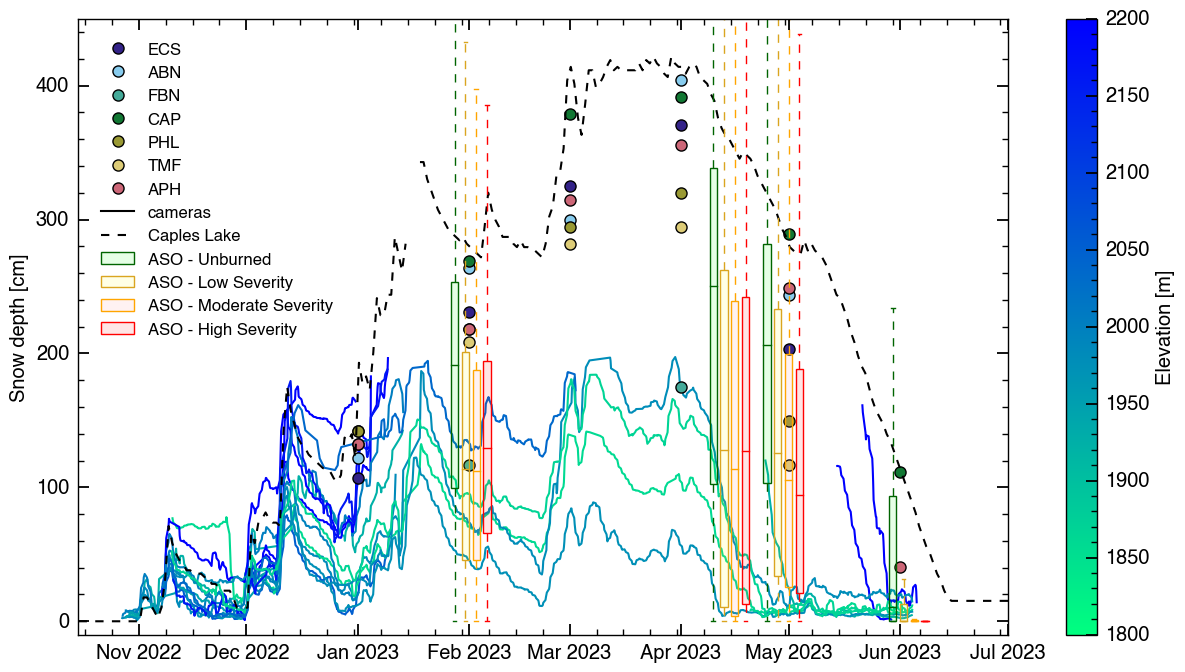

In [45]:
IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cameradates = []
cameraseries = []
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=get_file_name(fn)
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = gdf[gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)
        
        cameradates.append(data.index)
        cameraseries.append(smoothed * 12 * IN_TO_CM)
        

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'black', label = 'cameras')
l1 = 17

ax.plot(pd.DatetimeIndex(cap23.datetime), cap23.SNOWDEPTH * 2.54, linestyle = '--', label = 'Caples Lake')

handles, labels = ax.get_legend_handles_labels()
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))


# bp1 = ax.boxplot(inside_values, positions=dates_num, widths=3, showfliers=False, patch_artist=True)
#bp2 = ax.boxplot(outside_values, positions=dates_num + 7, widths=2, showfliers=False, patch_artist=True)

bp_u = ax.boxplot(unburned_values, positions=dates_num-3, widths=2, showfliers=False, patch_artist=True)
bp_l = ax.boxplot(low_values, positions=dates_num, widths=2, showfliers=False, patch_artist=True)
bp_m = ax.boxplot(moderate_values, positions=dates_num + 3, widths=2, showfliers=False, patch_artist=True)
bp_h = ax.boxplot(high_values, positions=dates_num + 6, widths=2, showfliers=False, patch_artist=True)


for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    # plt.setp(bp1[element], color='red')
    plt.setp(bp_u[element], color='darkgreen')
    plt.setp(bp_l[element], color='goldenrod')
    plt.setp(bp_m[element], color='orange')
    plt.setp(bp_h[element], color='red')
    
for patch in bp_u['boxes']:
    patch.set_facecolor((0, 1, 0 , 0.1)) 

for patch in bp_l['boxes']:
    patch.set_facecolor((1, 1, 0, 0.1)) 

for patch in bp_m['boxes']:
    patch.set_facecolor((1, 0.5, 0.5, 0.1))  

for patch in bp_h['boxes']:
    patch.set_facecolor((1, 0, 0, 0.1))  

handles.append(bp_u["boxes"][0])
handles.append(bp_l["boxes"][0])
handles.append(bp_m["boxes"][0])
handles.append(bp_h["boxes"][0])

labels.append("ASO - Unburned")
labels.append("ASO - Low Severity")
labels.append("ASO - Moderate Severity")
labels.append("ASO - High Severity")


ax.legend(handles[l1:], labels[l1:], loc = 'upper left')

months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# Format the x tick labels as Month, Year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.show()

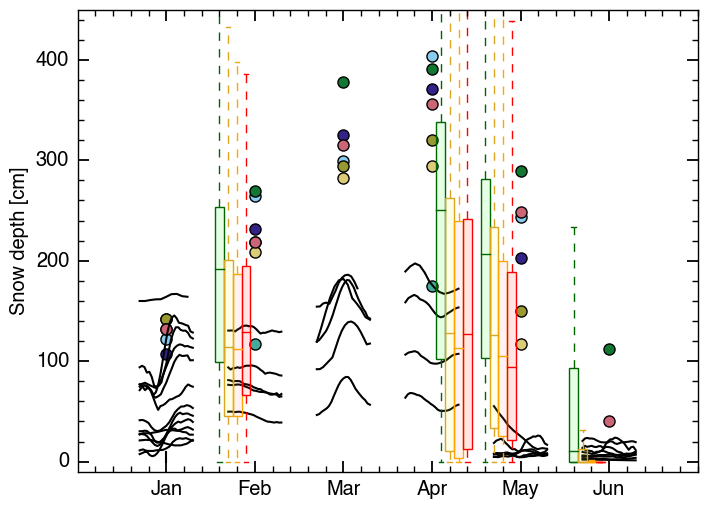

In [46]:
IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]

xpoints = [0,10,20,30,40,50,60,70,80]
xpoints_aso = np.array([10,35,40,50])
ccss_dates = [datetime.datetime(2023,1,1), datetime.datetime(2023,2,1), datetime.datetime(2023,3,1), datetime.datetime(2023,4,1),
              datetime.datetime(2023,5,1), datetime.datetime(2023,6,1), datetime.datetime(2023,7,1)]
fig, ax = plt.subplots()
for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(xpoints, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'black', label = 'cameras')
l1 = 17

# ax.plot(pd.DatetimeIndex(cap23.datetime), cap23.SNOWDEPTH * 2.54, linestyle = '--', label = 'Caples Lake')

ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))

for i,c in enumerate(cameraseries):
    dates = cameradates[i]
    for a, survey in enumerate(ccss_dates):
        try:
            idx = np.where((dates >= survey - pd.Timedelta(days=3)) & (dates <= survey + pd.Timedelta(days=3)))[0]
            xdata = np.linspace(xpoints[a]-3, xpoints[a]+3, len(idx))
            ax.plot(xdata, c[idx], '-', color = 'black')
        except: 
            print(i)
            continue

bp_u = ax.boxplot(unburned_values, positions=xpoints_aso-4, widths=1, showfliers=False, patch_artist=True)
bp_l = ax.boxplot(low_values, positions=xpoints_aso-3, widths=1, showfliers=False, patch_artist=True)
bp_m = ax.boxplot(moderate_values, positions=xpoints_aso-2, widths=1, showfliers=False, patch_artist=True)
bp_h = ax.boxplot(high_values, positions=xpoints_aso-1, widths=1, showfliers=False, patch_artist=True)


for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    # plt.setp(bp1[element], color='red')
    plt.setp(bp_u[element], color='darkgreen')
    plt.setp(bp_l[element], color='goldenrod')
    plt.setp(bp_m[element], color='orange')
    plt.setp(bp_h[element], color='red')
    
for patch in bp_u['boxes']:
    patch.set_facecolor((0, 1, 0 , 0.1)) 

for patch in bp_l['boxes']:
    patch.set_facecolor((1, 1, 0, 0.1)) 

for patch in bp_m['boxes']:
    patch.set_facecolor((1, 0.5, 0.5, 0.1))  

for patch in bp_h['boxes']:
    patch.set_facecolor((1, 0, 0, 0.1))  

handles.append(bp_u["boxes"][0])
handles.append(bp_l["boxes"][0])
handles.append(bp_m["boxes"][0])
handles.append(bp_h["boxes"][0])

labels.append("ASO - Unburned")
labels.append("ASO - Low Severity")
labels.append("ASO - Moderate Severity")
labels.append("ASO - High Severity")
ax.set_xticks(xpoints[0:6])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun'])
ax.set_xlim(-10,60)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[l1:], labels[l1:], loc = 'upper left')

plt.show()

In [49]:
## forest and burn severity ## 
# lfcc = xr.open_dataarray('/Users/cowherd/Downloads/LF2022_CC_230_CONUS/Tif/LC22_CC_230.tif').sel(band=1)
lfcc22 = xr.open_dataarray(f'{datadir}/tifs/lfcc2022_caldor.tif').sel(band=1)
lfcc20 = xr.open_dataarray(f'{datadir}/lfcc2020_caldor.tif').sel(band=1)
lfcc22 = lfcc22.rio.reproject_match(lfcc20) # there is a very small offset between the latlon of the two. this fixes that.
mtbs_cc = mtbs_rdnbr.rio.reproject_match(lfcc22).sel(band=1).band_data

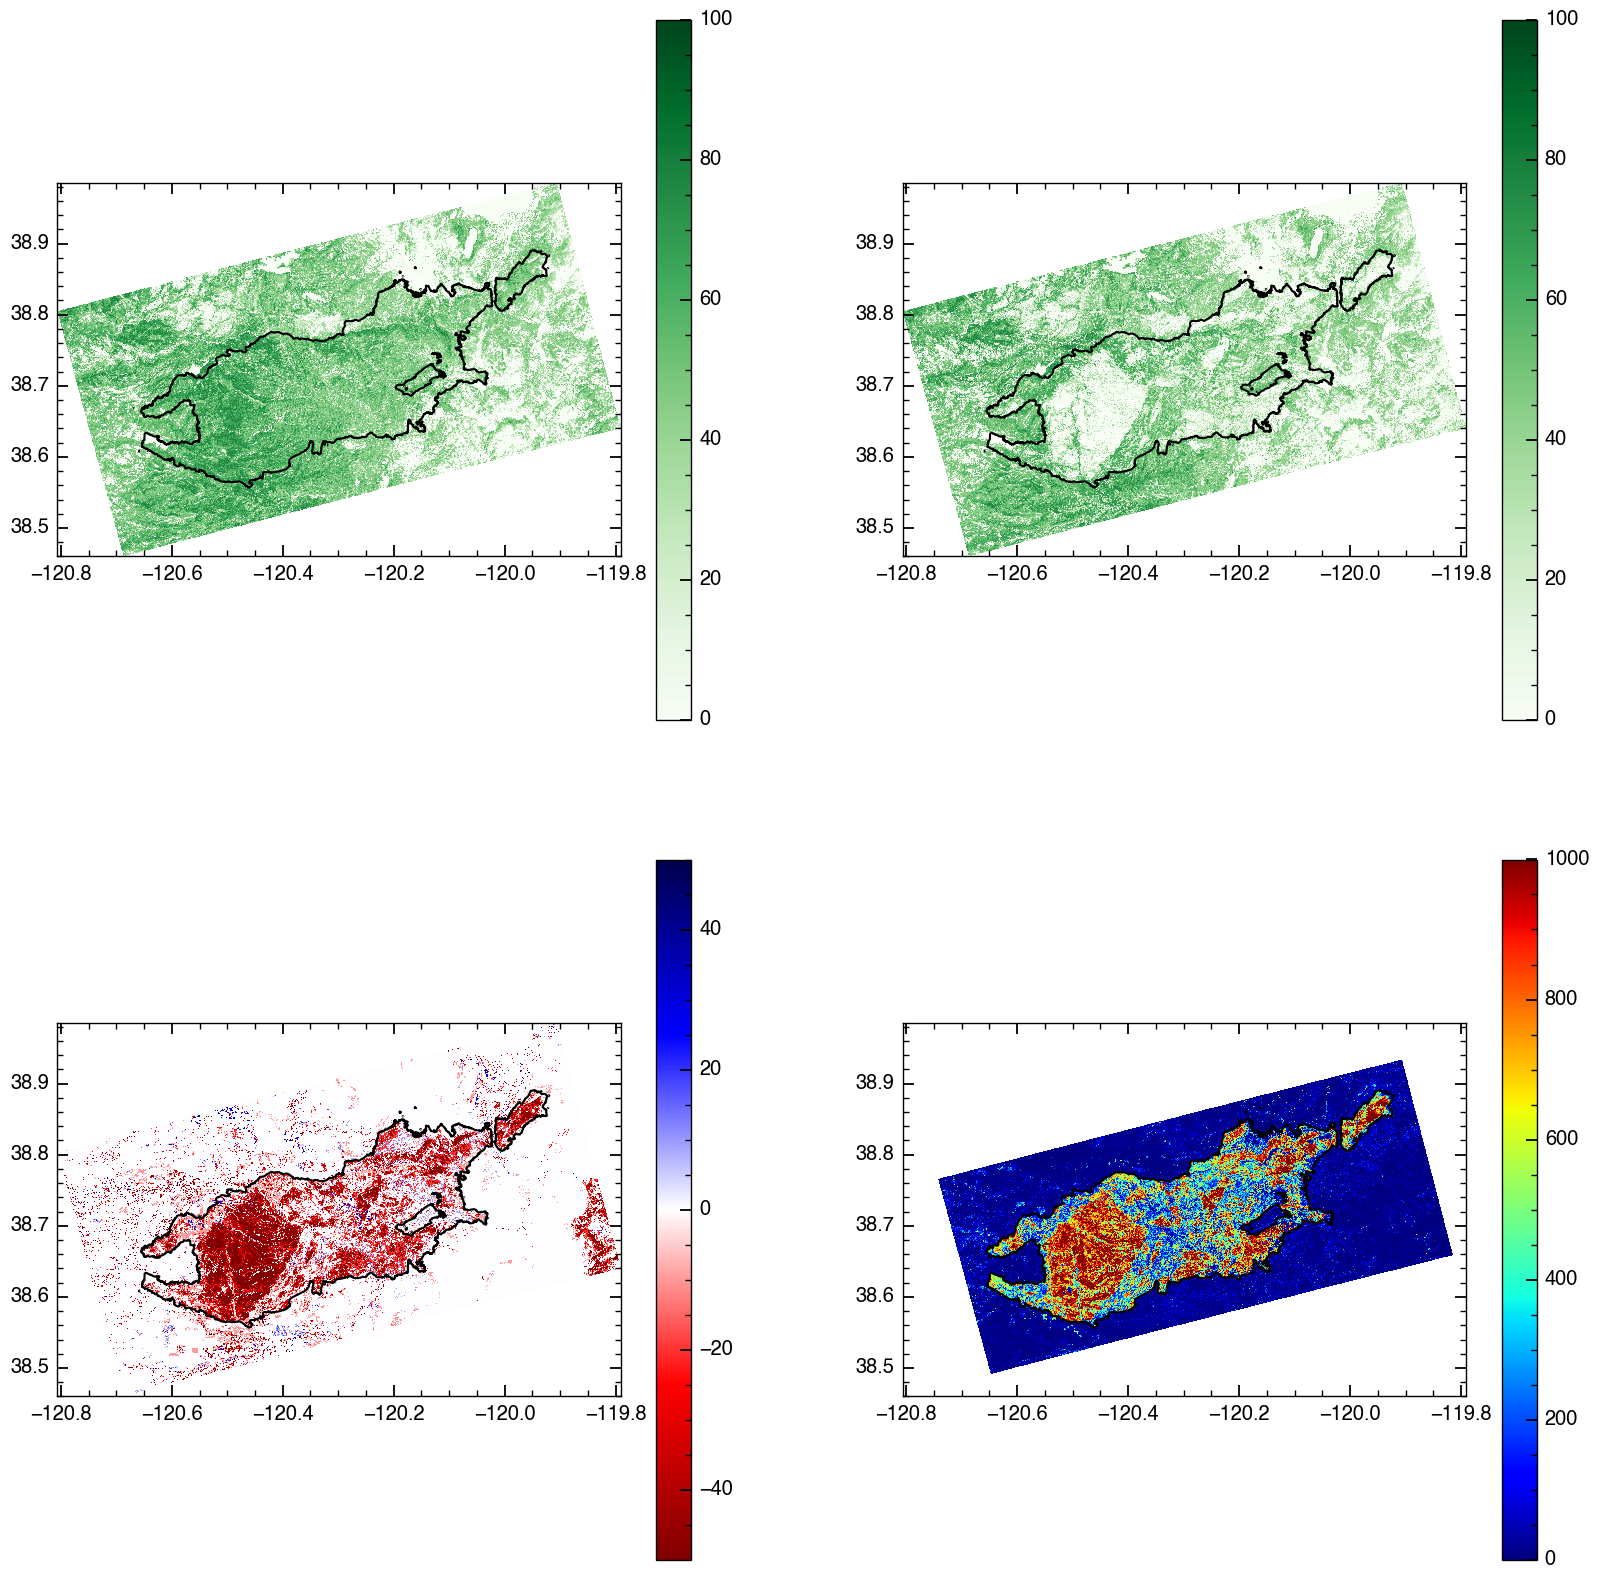

In [50]:
fig, ax = plt.subplots(2,2,figsize = (20,20))
ax = ax.flatten()
cb0 = ax[0].pcolormesh(lfcc20.x, lfcc20.y, lfcc20, cmap = 'Greens',vmin = 0, vmax = 100)
plt.colorbar(cb0, ax=ax[0])
cb1 = ax[1].pcolormesh(lfcc22.x, lfcc22.y, lfcc22, cmap = 'Greens', vmin = 0, vmax = 100)
plt.colorbar(cb1, ax=ax[1])
cb2 = ax[2].pcolormesh(lfcc22.x, lfcc22.y, lfcc22-lfcc20, cmap = 'seismic_r', vmin = -50, vmax = 50) 
plt.colorbar(cb2, ax=ax[2])
cb3 = ax[3].pcolormesh(mtbs_cc.x, mtbs_cc.y, mtbs_cc, cmap = 'jet', vmin = 0, vmax = 1000)
plt.colorbar(cb3, ax=ax[3])
for i in range(4):
    caldor.boundary.plot(ax = ax[i], color = 'black')
plt.show()

In [51]:

data = {
    'Name': ['Lake Audrain', 'Philipps', 'Caples Lake*', 'Tamarack Flat', 'Alpha*', 'Echo Summit', 'Forni Ridge*'],
    'Acronym': ['ABN', 'PHL', 'CAP', 'TMF', 'ALP', 'ECS', 'FRN'],
    'Latitude': [38.81983, 38.81800, 38.71079, 38.80300, 38.80414, 38.82852, 	38.803970],
    'Longitude': [-120.03932, -120.02700, -120.04158, -120.10300, -120.21564, -120.03898, -120.215919],
    'Elevation [ft]': [7300, 6800, 8000, 6550, 7600, 7450, 7600],
    'Year': [1941, 1941, 1939, 1939, 1965, 1940, None],
    'Agency': ['USFS', 'DWR', 'DWR', 'DWR', 'DWR', 'USFS', 'USBR']
}

cdec = pd.DataFrame(data)
geometry = [Point(lon, lat) for lon, lat in zip(cdec['Longitude'], cdec['Latitude'])]
cdec = gpd.GeoDataFrame(cdec, geometry=geometry, crs='EPSG:4326')
cdec.to_file('../data/cdec.shp')

/opt/anaconda3/envs/snow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_1722/1292936727.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cdec.to_file('../data/cdec.shp')


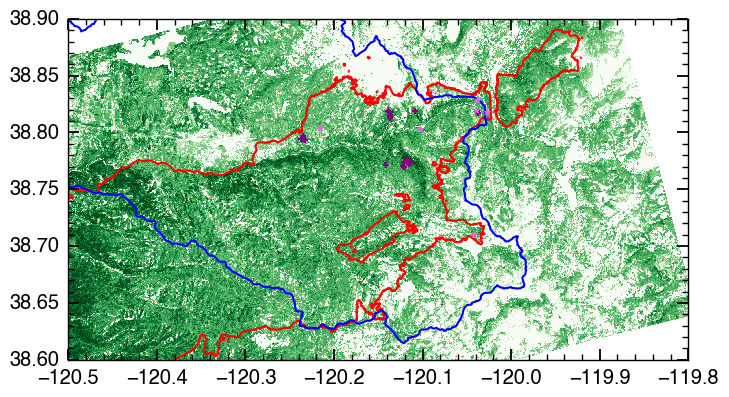

In [52]:
## pre-fire canopy cover: snow courses, all fire and sfa reagions, and my sites ## 
fig, ax  = plt.subplots()
ax.pcolormesh(lfcc20.x, lfcc20.y, lfcc20, cmap = 'Greens')
caldor.boundary.plot(ax = ax, color = 'red')  
sfa.boundary.plot(ax = ax, color = 'blue')

caldormeta.plot(ax=ax, color='purple', alpha=1, markersize=15, marker='+', zorder=5, label = 'Field Sites')
cdec.plot(ax=ax, color='orchid', markersize=15, marker='*', zorder=5, alpha=1, label = 'Snow Courses')

ax.set_xlim((-120.5, -119.8))
ax.set_ylim((38.6, 38.9))
plt.show()



In [53]:

def get_raster_values(raster, points, size = 2):
    values = []
    for point in points.geometry:
        xdiff = (raster.x[1] - raster.x[0]).values.flatten()[0]
        ydiff = (raster.y[1] - raster.y[0]).values.flatten()[0]
        xmin = point.x - ((size//2) * xdiff)
        xmax = point.x + ((size//2) * xdiff)
        ymin = point.y - ((size//2) * ydiff)
        ymax = point.y + ((size//2) * ydiff)
        val_slice = raster.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))
        values.append(val_slice.values.flatten())
    return values

cdec_values = get_raster_values(lfcc20, cdec)
caldormeta_values = get_raster_values(lfcc20, caldormeta)
cdec_lfcc20 = np.array(cdec_values).flatten()
caldor_lfcc20 = np.array(caldormeta_values).flatten()

cdec_values = get_raster_values(lfcc22, cdec)
caldormeta_values = get_raster_values(lfcc22, caldormeta)
cdec_lfcc22 = np.array(cdec_values).flatten()
caldor_lfcc22 = np.array(caldormeta_values).flatten()

mtbs_array = mtbs_rdnbr.sel(band=1).band_data
mtbs_array = mtbs_array.rio.reproject_match(lfcc22)
cdec_values = get_raster_values(mtbs_array, cdec)
caldormeta_values = get_raster_values(mtbs_array, caldormeta)
cdec_mtbs = np.array(cdec_values).flatten()
caldor_mtbs = np.array(caldormeta_values).flatten()

ccdiff = lfcc22-lfcc20
from scipy.signal import convolve2d
# Define a kernel for smoothing
kernel = np.array([[1, 1, 1, 1],
                   [1, 1, 1, 1 ],
                   [1, 1, 1, 1 ],
                   [1, 1, 1 ,1]])
kernel = kernel / np.nansum(kernel)

# Apply the kernel to the raster
smoothed_ccdiff = convolve2d(ccdiff, kernel, mode='same')
ccdiff.values = smoothed_ccdiff
diff_in = ccdiff.rio.clip(caldor.geometry, invert=False)
diff_in = diff_in.rio.clip(sfa.geometry, invert = False)
diff_in_vals = diff_in.values.flatten()
diff_in_vals = diff_in_vals[~np.isnan(diff_in_vals)]


In [54]:
lfcc20_in = lfcc20.rio.clip(caldor.geometry, invert=False)
lfcc20_in = lfcc20_in.rio.clip(sfa.geometry, invert = False)
lfcc20_in_vals = lfcc20_in.values.flatten()
lfcc20_in_vals = lfcc20_in_vals[~np.isnan(lfcc20_in_vals)]

lfcc22_in = lfcc22.rio.clip(caldor.geometry, invert=False)
lfcc22_in = lfcc22_in.rio.clip(sfa.geometry, invert = False)
lfcc22_in_vals = lfcc22_in.values.flatten()
lfcc22_in_vals = lfcc22_in_vals[~np.isnan(lfcc22_in_vals)]

mtbs_in = mtbs_array.rio.clip(caldor.geometry, invert=False)
mtbs_in = mtbs_in.rio.clip(sfa.geometry, invert = False)
mtbs_in_vals = mtbs_in.values.flatten()
mtbs_in_vals = mtbs_in_vals[~np.isnan(mtbs_in_vals)]


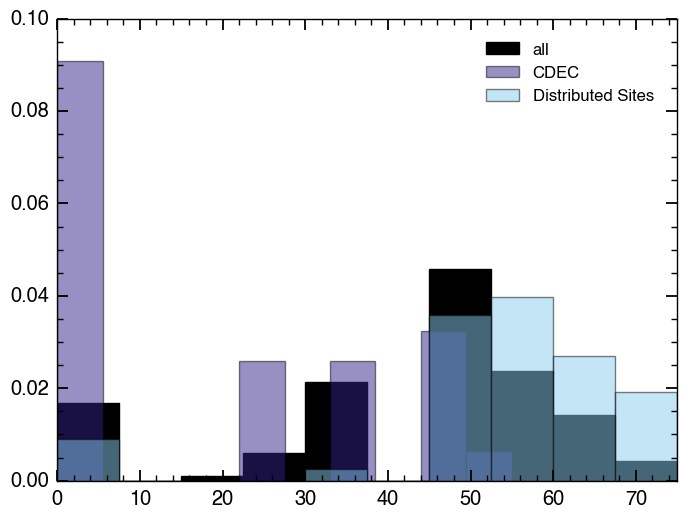

In [55]:
fig,ax = plt.subplots(1)
ax.hist(lfcc20_in_vals, density = True, label = 'all')
ax.hist(cdec_lfcc20, density = True, alpha = 0.5, label = 'CDEC')
ax.hist(caldor_lfcc20, density = True, alpha = 0.5, label = 'Distributed Sites')
ax.legend()
plt.show()

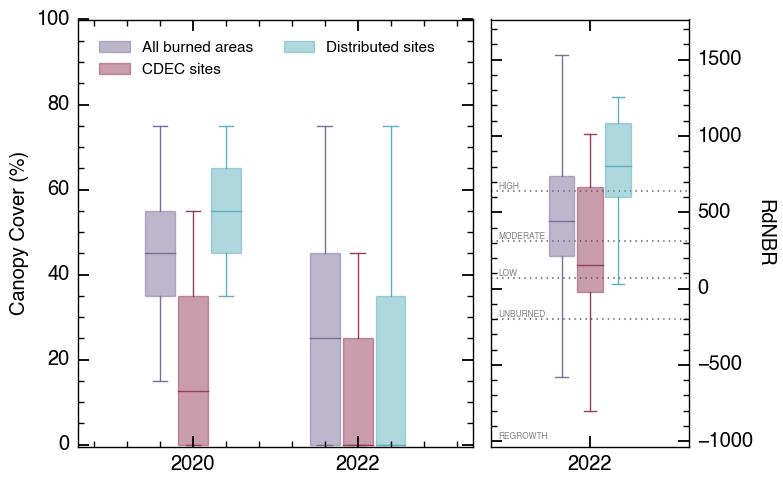

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = [[lfcc20_in_vals, cdec_lfcc20, caldor_lfcc20],
        [lfcc22_in_vals, cdec_lfcc22, caldor_lfcc22],
        [mtbs_in_vals, cdec_mtbs, caldor_mtbs]]

# Define the labels
mylabels = ['2020', '2022', '2022']
mycategs = ['All burned areas', 'CDEC sites', 'Distributed sites']

miller_thode = [-200, 69, 315, 640] 
miller_thode_labels = ['Unburned', 'Low', 'Moderate', 'High']
# Define the colors
colors = ['blue', 'red', 'green']

colors = ['#7A6F9B','#963D5A','#5EB1BF']

# Create the figure and axis
fig, ax = plt.subplots(1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [2, 1]})

bps = []
for i, group in enumerate(data):
    for j, dataset in enumerate(group):
        if i < 2:
            bp = ax[0].boxplot([dataset], positions=[i + j * 0.2 - 0.2], widths=0.18,
                       patch_artist=True, boxprops=dict(facecolor=colors[j]), whiskerprops=dict(linestyle ='-'), showfliers = False)
            
        else:
            bp = ax[1].boxplot([dataset], positions=[i + j * 0.2 - 0.2], widths=0.18,
                       patch_artist=True, boxprops=dict(facecolor=colors[j]), whiskerprops=dict(linestyle ='-'), showfliers = False)
            
        bps.append(bp)
        
handles = []
labels = []

for k, bp in enumerate(bps):
    i = k%3
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=colors[i])    
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i]) 
        patch.set_alpha(0.5)
    handles.append(bp["boxes"][0])
    labels.append(mylabels[i])

xadj = [0,+0.2,0,+0.2]
for i, ht in enumerate(miller_thode):
    ax[1].axhline(ht, color = 'gray', linestyle = ':', zorder = 0, label = f'{ht} RdNBR')
    ax[1].text(1.35, ht, f'{miller_thode_labels[i]}'.upper(), color = 'gray', fontsize = 6, va = 'bottom', rotation = 0)
    # diff = -150
    # ax[1].text(1.2 + xadj[i], ht+diff, f'{miller_thode_labels[i]}'.upper(), color = 'gray', fontsize = 8, va = 'center', rotation = 90)
ax[1].text(1.35,-1000, 'REGROWTH', color = 'gray', fontsize = 6, va = 'bottom', rotation = 0)
ax[1].yaxis.set_label_position('right')
ax[1].tick_params(left=True, right=True, top=True, bottom=True, labelleft = False, labelright = True)

ax[1].set_ylabel('RdNBR', rotation=270, labelpad=15)
ax[1].set_xticks([2])
ax[1].set_xticklabels(['2022'])


ax[0].set_xticks(np.arange(len(mylabels[0:2])))
ax[0].set_xticklabels(mylabels[0:2])

ax[0].set_ylim((-0.5, 100))
ax[0].set_ylabel('Canopy Cover (%)')
ax[1].set_ylabel('RdNBR')

ax[0].legend(handles = handles[0:3], labels = mycategs[0:3], loc='upper left', ncol= 2, fontsize = 11)
plt.tight_layout()
plt.savefig('../figures/lfcc_rdnbr.png', dpi = 800)
plt.show()

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = [[lfcc20_in_vals, cdec_lfcc20, caldor_lfcc20],
        [lfcc22_in_vals, cdec_lfcc22, caldor_lfcc22],
        [mtbs_in_vals, cdec_mtbs, caldor_mtbs],
        [diff_in_vals, cdec_diff, caldor_diff]]

# Define the labels
mylabels = ['2020', '2022', '2022']
mycategs = ['All burned areas', 'CDEC sites', 'Distributed sites']

miller_thode = [-200, 69, 315, 640] 
miller_thode_labels = ['Unburned', 'Low', 'Moderate', 'High']
# Define the colors
colors = ['blue', 'red', 'green']

colors = ['#7A6F9B','#963D5A','#5EB1BF']

# Create the figure and axis
fig, ax = plt.subplots(1, 3, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1, 1]})

bps = []
for i, group in enumerate(data):
    for j, dataset in enumerate(group):
        if i < 2:
            bp = ax[0].boxplot([dataset], positions=[i + j * 0.2 - 0.2], widths=0.18,
                       patch_artist=True, boxprops=dict(facecolor=colors[j]), whiskerprops=dict(linestyle ='-'), showfliers = True)
            if j > 3:
                jitter = np.random.uniform(i + j * 0.2 - 0.3, i + j * 0.2 - 0.1, size=len(dataset))
                ax[0].plot(jitter, dataset, 'o', color = colors[j], alpha = 0.5)
                
        elif i==2:
            bp = ax[2].boxplot([dataset], positions=[i + j * 0.2 - 0.2], widths=0.18,
                       patch_artist=True, boxprops=dict(facecolor=colors[j]), whiskerprops=dict(linestyle ='-'), showfliers = False)
            if j > 3:
                jitter = np.random.uniform(i + j * 0.2 - 0.3, i + j * 0.2 - 0.1, size=len(dataset))
                ax[2].plot(jitter, dataset, 'o', color = colors[j], alpha = 0.5)
        elif i==3:
            bp = ax[1].boxplot([dataset], positions=[i + j * 0.2 - 0.2], widths=0.18,
                       patch_artist=True, boxprops=dict(facecolor=colors[j]), whiskerprops=dict(linestyle ='-'), showfliers = True)
            if j > 3:
                jitter = np.random.uniform(i + j * 0.2 - 0.3, i + j * 0.2 - 0.1, size=len(dataset))
                ax[1].plot(jitter, dataset, 'o', color = colors[j], alpha = 0.5)

            
        bps.append(bp)
        
handles = []
labels = []

for k, bp in enumerate(bps):
    i = k%3
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=colors[i])    
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i]) 
        patch.set_alpha(0.5)
    handles.append(bp["boxes"][0])
    labels.append(mylabels[i])

xadj = [0,+0.2,0,+0.2]
for i, ht in enumerate(miller_thode):
    ax[2].axhline(ht, color = 'gray', linestyle = ':', zorder = 0, label = f'{ht} RdNBR')
    ax[2].text(1.35, ht, f'{miller_thode_labels[i]}'.upper(), color = 'gray', fontsize = 6, va = 'bottom', rotation = 0)
ax[2].text(1.35,-1000, 'REGROWTH', color = 'gray', fontsize = 6, va = 'bottom', rotation = 0)
ax[1].yaxis.set_label_position('right')
ax[1].tick_params(left=True, right=True, top=True, bottom=True, labelleft = False, labelright = True)

ax[1].set_ylabel('RdNBR', rotation=270, labelpad=15)
ax[1].set_xticks([2])
ax[1].set_xticklabels(['2022'])


ax[0].set_xticks(np.arange(len(mylabels[0:2])))
ax[0].set_xticklabels(mylabels[0:2])

ax[0].set_ylim((-0.5, 100))
ax[0].set_ylabel('Canopy Cover (%)')
ax[1].set_ylabel('RdNBR')

ax[0].legend(handles = handles[0:3], labels = mycategs[0:3], loc='upper left', ncol= 2, fontsize = 11)
plt.tight_layout()
plt.show()

NameError: name 'cdec_diff' is not defined

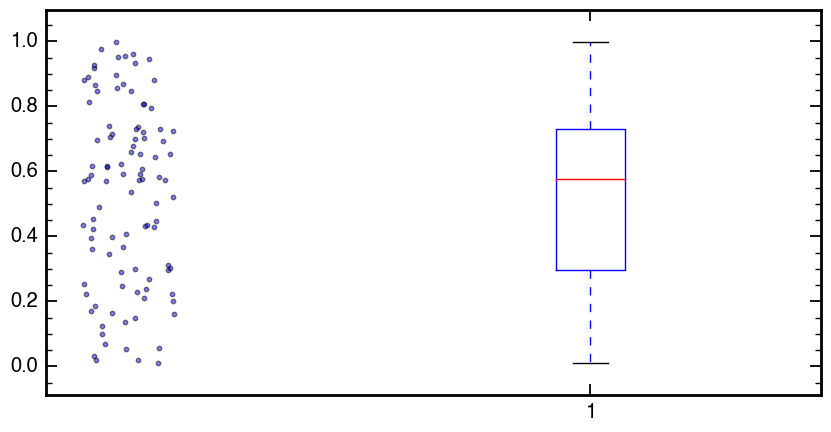

In [362]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mydata = np.random.rand(100)
# Box plot
ax.boxplot(mydata)
np.random.seed(0)
jiggle = np.random.uniform(-0.1, 0.1, size=len(mydata))
ax.scatter(jiggle, mydata, alpha=0.5, s=10)
# ax.set_xlim(-0.2, 0.2)
# ax.set_xticks([])
plt.show()

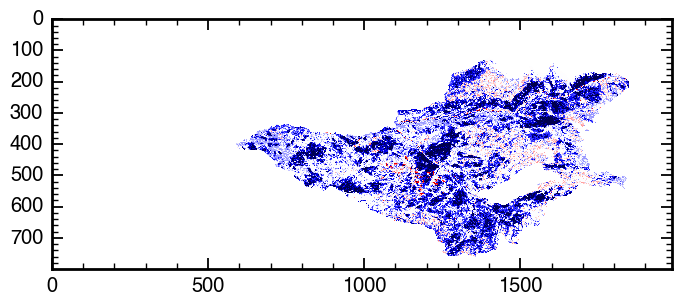

In [351]:
plt.imshow(diff_in, cmap ='seismic', vmin = -50, vmax = 50)

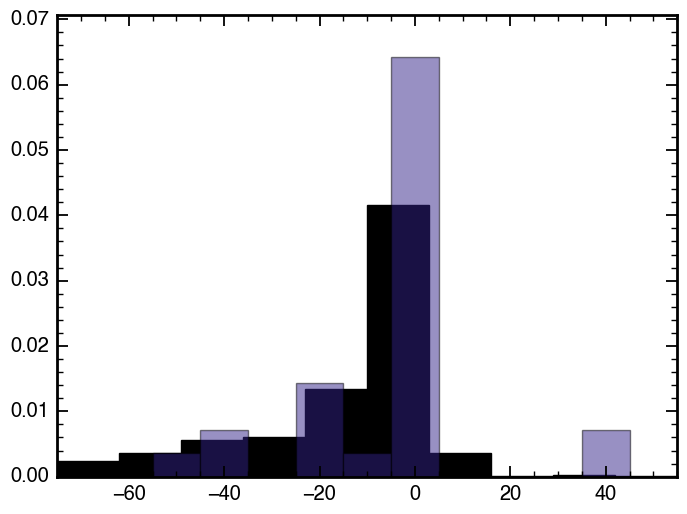

In [355]:
plt.hist(diff_in_vals, bins = 10, density = True)
plt.hist(cdec_diff, bins = 10, density = True, alpha = 0.5)
plt.show()

In [247]:
i

3

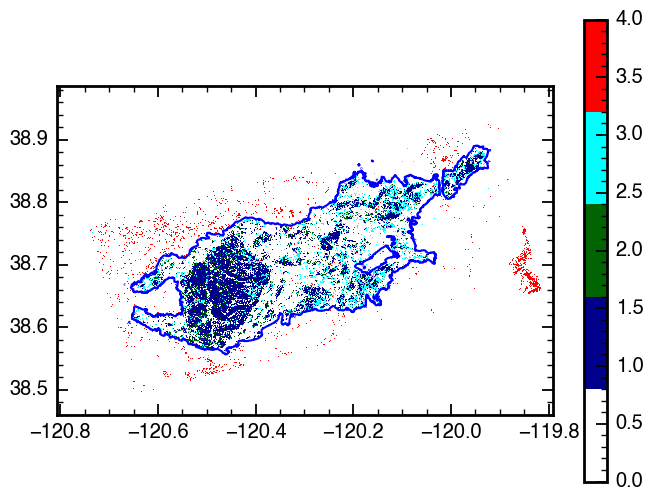

In [69]:
# [-200, 69, 315, 640, 5000]  #  miller and thode

diffcc = lfcc22-lfcc20

combined_map = np.zeros_like(diffcc)



combined_map[(diffcc < -30) & (mtbs_cc > 640)] = 1 # high loss, high burn
combined_map[(diffcc >= -30) & (diffcc < -20) & (mtbs_cc > 640)] = 2 # moderate loss, high burn
combined_map[(diffcc >= -20) & (diffcc <= 0) & (mtbs_cc > 640)] = 3 # any loss, high burn

combined_map[(diffcc < -20) & (mtbs_cc < 69)] = 4 # high loss, unburned

categories = ['Agree-high loss', 'Agree-moderate loss', 'Agree - some loss', 
              'Disagree -  loss without burn']
colors = ['white','darkblue', 'darkgreen', 'cyan', 'red']
cmap = mcolors.ListedColormap(colors)
fig, ax = plt.subplots()
cbar = ax.pcolormesh(lfcc20.x, lfcc20.y, combined_map, cmap = cmap)
caldor.boundary.plot(ax=ax)
plt.colorbar(cbar)
plt.show()
# plt.imshow(combined_map)

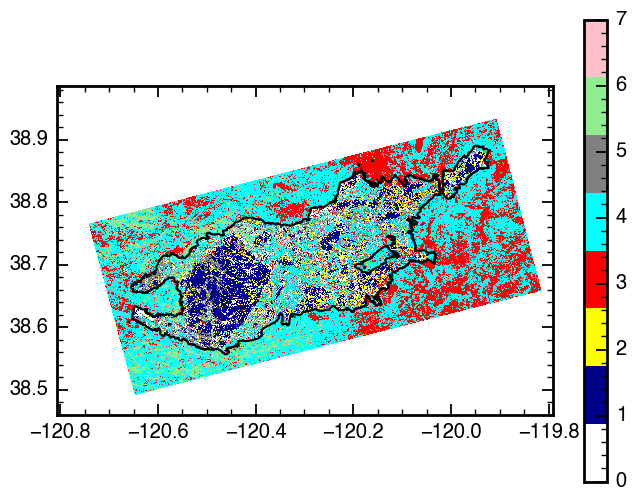

In [95]:
# [-200, 69, 315, 640, 5000]  #  miller and thode
combined_map_22 = np.zeros_like(lfcc22)
combined_map_22[(lfcc22 < 10) & (mtbs_cc > 640)] = 1 # very low cover, high burn
combined_map_22[(lfcc22 >=10) & (lfcc22 < 30) & (mtbs_cc > 640)] = 2 # low cover, high burn
combined_map_22[(lfcc22 < 10) & (mtbs_cc < 315)] = 3 # low cover, low burn
combined_map_22[(lfcc22 > 10) & (mtbs_cc < 315)] = 4 # high cover, low burn
combined_map_22[(lfcc22 < 60) & (lfcc22 > 30) & (mtbs_cc > 315)]  = 5 # medium cover, high burn
combined_map_22[(lfcc22 > 60) & (mtbs_cc < 315)]  = 6 # high cover, low burn
combined_map_22[(lfcc22 > 60) & (mtbs_cc > 640)] = 7 #high cover cover, high burn




colors = ['white','darkblue', 'yellow', 'red', 'cyan', 'gray', 'lightgreen','pink']
cmap = mcolors.ListedColormap(colors)
fig, ax = plt.subplots()
cbar = ax.pcolormesh(lfcc20.x, lfcc20.y, combined_map_22, cmap = cmap)
caldor.boundary.plot(ax=ax, color = 'black')
plt.colorbar(cbar)
plt.show()
